In [1]:
# This is the source code of numerical simulations for the work presented in 
# Y Luo, C-L Ho, B R Helliker and E Katifori, 
# Leaf water storage and robustness to intermittent drought: A spatially explicit capacitive model for leaf hydraulics
# arXiv:2106.08939

%pylab inline

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Build up a chain-like, one-dimensional network with 100 nodes

n = 100
G = nx.Graph()
G = nx.path_graph(n+1)
G.remove_node(0)    # Node 0 being leaf base, the leaf xylem starts with node 1.

In [3]:
# Water potentials at boundaries and parameters at each node

P0 = 0.        # Water source potential at base (PSI_0)
R0 = 0.02      # Xylem hydraulic resistance between neighboring nodes
Pa = -100.     # Atmospheric potential (PSI_a)

for i in G.nodes():
    G.nodes[i]['Ra'] = 5000.    # Xylem-to-air resistance at each node
    G.nodes[i]['Pa'] = Pa       # Atmopheric condition is uniform along leaf blade
    
for j in G.edges():
    G.edges[j]['R'] = R0        # Xylem resistance is uniform along leaf blade

In [4]:
# Calculate well-watered steady state (using methods at the end of "Numerical simulation of general capacitive networks")

P_over_R = []    # Calculate column vector a
for i in G.nodes():
    P_over_R.append(G.nodes[i]['Pa']/G.nodes[i]['Ra'])
P_over_R[0] += P0/R0

ss_mat = np.zeros((n,n))    # Calculate matrix B
for i in G.nodes():
    ss_mat[i-1,i-1] = 1/G.nodes[i]['Ra']
    for j in G.adj[i]:
        ss_mat[i-1,i-1] += 1/G[i][j]['R']
        ss_mat[i-1,j-1] = -1/G[i][j]['R']
ss_mat[0,0] += 1/R0

P_vec = np.dot(inv(ss_mat),P_over_R)    # Column vector y containing steady-state water potentials at all nodes
P_vec = np.insert(P_vec, 0, 0.)         # Add source potential at the base

Text(0, 0.5, 'Water potential')

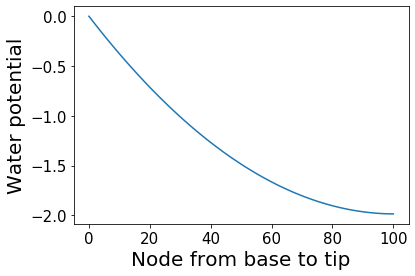

In [5]:
# The steady state of xylem water potential in Figure 3

plot(np.arange(101),P_vec)
plt.tick_params(labelsize=15)
plt.xlabel("Node from base to tip",size=20)
plt.ylabel("Water potential",size=20)

In [8]:
# Dymanic simulations use methods in "Numerical simulation of general capacitive networks"

# Simulate the dynamics of a well-watered leaf excised at time=0 (water source cut off)

P_init = np.delete(P_vec,0)         # Initialize leaf water status
for i in G.nodes():
    G.node[i]["P"] = P_init[i-1]    # Xylem water potentials initially at the above steady state
    G.node[i]["C"] = 0.005          # Capacitance at each node
    G.node[i]["Rc"] = 100.          # Xylem-to-capacitor resistance at each node
dt = 0.01                           # Simulation timestep
Pn = []                             # Array containing xylem water potential distribution after t=1,2,...,100

for ss in range(100):               # Total simulation time=100; save data at each integer time point
    for tt in range(100):
        Bi = []                     # Calculate column vector b
        for i in G.nodes():
            bb = (G.node[i]["Pa"]-G.node[i]["P"]) / (G.node[i]["C"]*G.node[i]["Rc"]*G.node[i]["Ra"])
            for j in G.adj[i]:
                bb += (G.node[j]["P"]-G.node[i]["P"]) / (G.node[i]["C"]*G.node[i]["Rc"]*G[i][j]["R"])
            Bi.append(bb)
        tt_mat = np.zeros((n,n))    # Calculate matrix A
        for i in G.nodes():
            tt_mat[i-1,i-1] = 1/G.node[i]['Ra'] + 1/G.node[i]['Rc']
            for j in G.adj[i]:
                tt_mat[i-1,i-1] += 1/G[i][j]['R']
                tt_mat[i-1,j-1] = -1/G[i][j]['R']
        Pt_vec = np.dot(inv(tt_mat),Bi)    # Calculate column vector x
        for i in G.nodes():
            G.node[i]["P"] += dt*Pt_vec[i-1]    # Update water potential at each node after dt=0.01
    P_temp = []                     # Temporary array containing instant water potential distribution
    for i in G.nodes():
        P_temp.append(G.node[i]["P"])
    Pn.append(P_temp)               # Arrary reads in data at t=1,2,...,100

(-100, 0)

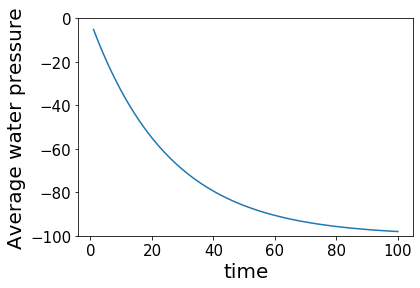

In [11]:
avg_Pn = []    # Average xylem potential at t=1,2,...,100
for p_n in Pn:
    avgP = 0.
    for i in range(n):
        avgP += p_n[i]/n
    avg_Pn.append(avgP)

# Change of average water potential in xylem in Figure S1 (a)
plot(np.arange(1,101),avg_Pn)
plt.tick_params(labelsize=15)
plt.xlabel("time",size=20)
plt.ylabel("Average water potential",size=20)
plt.ylim([-100,0])

(0, 2)

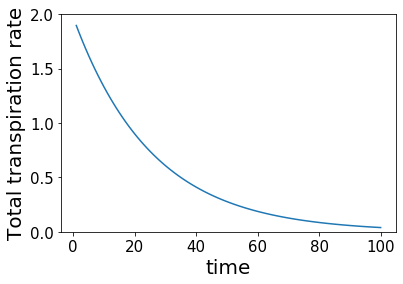

In [12]:
ext_In = []    # Total transpiration current at t=1,2,...,100
for p_n in Pn:
    extI = 0.
    for i in G.nodes():
        extI += (p_n[i-1]-G.node[i]["Pa"])/G.node[i]["Ra"]
    ext_In.append(extI)
    
# Change of total transpiration through stomata in Figure 4(a)
plot(np.arange(1,101),ext_In)
plt.tick_params(labelsize=15)
plt.xlabel("time",size=20)
plt.ylabel("Total transpiration rate",size=20)
plt.ylim([0,2])

In [13]:
# Simulate the dynamics of leaf experiencing sudden increase of VPD

P_init = np.delete(P_vec,0)        # Initialize leaf water status with the above steady state
for i in G.nodes():
    G.node[i]["P"] = P_init[i-1]
    G.node[i]["C"] = 0.01          # Capacitance at each node
    G.node[i]["Rc"] = 2500.        # Xylem-to-capacitor resistance at each node
    G.node[i]["Pa"] = -150.        # Instantly decrease the atmospheric potential from -100 to -150 at time=0
dt = 0.01                          # Simulation timestep
Pn = []                            # Array containing xylem water potential distribution after t=1,2,...,100

for ss in range(100):              # Total simulation time=100; save data at each integer time point
    for tt in range(100):
        Bi = []                    # Calculate column vector b
        for i in G.nodes():
            bb = (G.node[i]["Pa"]-G.node[i]["P"]) / (G.node[i]["C"]*G.node[i]["Rc"]*G.node[i]["Ra"])
            for j in G.adj[i]:
                bb += (G.node[j]["P"]-G.node[i]["P"]) / (G.node[i]["C"]*G.node[i]["Rc"]*G[i][j]["R"])
            Bi.append(bb)
        Bi[0] += (P0 - G.node[1]["P"]) / (G.node[1]["C"]*G.node[1]["Rc"]*R0)    # Effect of water source potential
        tt_mat = np.zeros((n,n))   # Calculate matrix A
        for i in G.nodes():
            tt_mat[i-1,i-1] = 1/G.node[i]['Ra'] + 1/G.node[i]['Rc']
            for j in G.adj[i]:
                tt_mat[i-1,i-1] += 1/G[i][j]['R']
                tt_mat[i-1,j-1] = -1/G[i][j]['R']
        tt_mat[0,0] += 1/R0        # Effect of the existence of water source
        Pt_vec = np.dot(inv(tt_mat),Bi)    # Calculate column vector x
        for i in G.nodes():
            G.node[i]["P"] += dt*Pt_vec[i-1]    # Update water potential at each node after dt=0.01
    P_temp = []                        # Temporary array containing instant water potential distribution
    for i in G.nodes():
        P_temp.append(G.node[i]["P"])
    Pn.append(P_temp)      # Arrary reads in data at t=1,2,...,100

Text(0, 0.5, 'Average water potential')

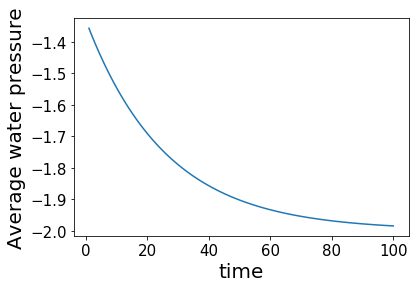

In [14]:
avg_Pn = []    # Average xylem potential at t=1,2,...,100
for p_n in Pn:
    avgP = 0.
    for i in range(n):
        avgP += p_n[i]/n
    avg_Pn.append(avgP)

# Change of average water potential in xylem as the black solid curve in Figure 5 (b)
plot(np.arange(1,101),avg_Pn)
plt.tick_params(labelsize=15)
plt.xlabel("time",size=20)
plt.ylabel("Average water potential",size=20)

Text(0, 0.5, 'Water potential')

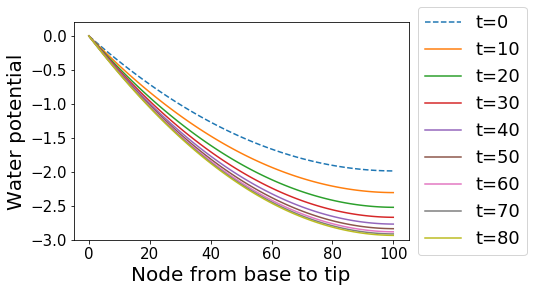

In [18]:
# Change of water potential distribution in xylem in Figure 6

xx = np.arange(101)
plot(xx, P_vec, linestyle="--", label="t=0")
plt.ylim((-3.,0.2))

for i in range(1,9):
    plot(xx,np.insert(Pn[10*i-1], 0, 0.),label=r"t="+str(10*i))
plt.tick_params(labelsize=15)
plt.legend(loc='center left',fontsize=18, bbox_to_anchor=(1., 0.5))
plt.xlabel("Node from base to tip",size=20)
plt.ylabel("Water potential",size=20)